In [1]:
from astroML.datasets import generate_mu_z
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
#from astropy import constants
from astropy.cosmology import LambdaCDM
from scipy.integrate import quad
import scipy.stats
import emcee
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import corner
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity



#from sklearn.linear_model import LinearRegression
#from astroML.linear_model import PolynomialRegression
#from astroML.linear_model import NadarayaWatson
#from astroML.linear_model import BasisFunctionRegression
#
#from sklearn.model_selection import learning_curve
#from sklearn.model_selection import train_test_split
#from tqdm import tqdm

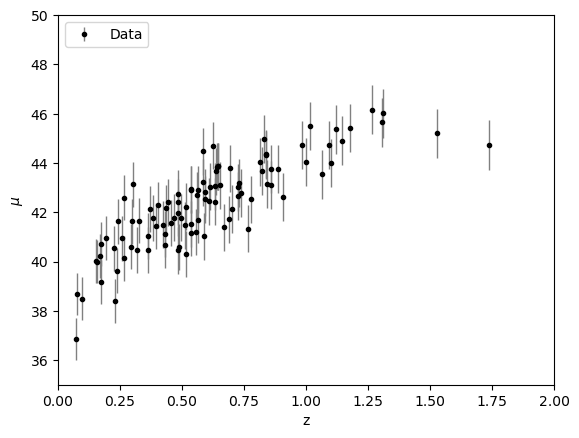

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [3]:
z_grid = np.linspace(0.05, 2., 1000)

## GPR

In [4]:
kernel = ConstantKernel() * RBF()
gp = GaussianProcessRegressor(kernel=kernel, alpha = dmu**2, n_restarts_optimizer=50)
gp.fit(z_sample[:, np.newaxis], mu_sample)

GaussianProcessRegressor(alpha=array([0.84387183, 0.91812087, 0.89001003, 0.94522717, 0.94422381,
       0.86154897, 0.86230499, 0.94838417, 0.9933467 , 0.9646779 ,
       0.87701523, 0.89976228, 0.92772472, 0.93248803, 0.87910942,
       0.90886653, 0.90007965, 0.74796941, 0.94290888, 0.96641079,
       0.87820976, 0.91709206, 0.80479835, 0.87887073, 0.98216481,
       0.92265029, 0.8835475 , 0.94586178, 0.86985...
       0.93684146, 0.91281498, 0.89527413, 0.81855684, 0.85259287,
       0.97119502, 0.88669278, 0.90504074, 0.72518962, 0.86689404,
       0.88987903, 0.91659546, 0.97685316, 0.91867826, 0.93138181,
       0.83270862, 0.93814442, 0.95430226, 0.9199094 , 0.89010136,
       0.83350663, 0.90995601, 0.90388843, 0.98995206, 0.89661359,
       0.90000008, 0.90519576, 0.95184399, 0.79454928, 0.92548723]),
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=50)

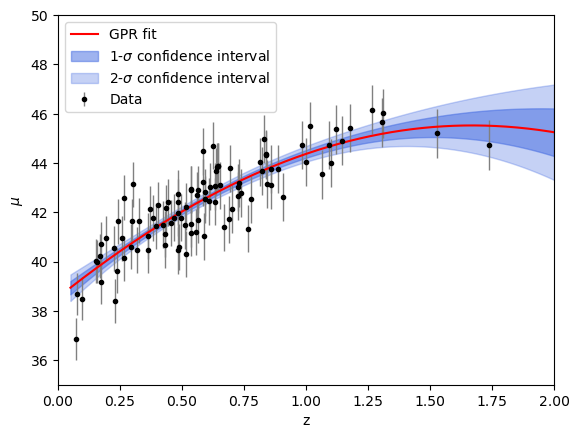

In [5]:
fit, fit_err = gp.predict(z_grid[:, np.newaxis], return_std=True)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(z_grid, fit, color = 'red', label = 'GPR fit')
plt.fill_between(z_grid, fit+fit_err, fit-fit_err, color = 'royalblue', alpha = 0.5, label = r'1-$\sigma$ confidence interval')
plt.fill_between(z_grid, fit+2*fit_err, fit-2*fit_err, color = 'royalblue', alpha = 0.3, label = r'2-$\sigma$ confidence interval')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Parametric fit

In [6]:
H_min, H_max = 50, 100
omega_min, omega_max = 0.1, 1

theta_guess = [70, 0.3]
labels = [r'$H_0$', r'$\Omega_{m}$']

In [81]:
def model(z, theta):
    H, omega = theta
    cosmological = LambdaCDM(H0 = H, Om0 = omega, Ode0= 1-omega)
    return cosmological.distmod(z).value

#### MCMC

In [8]:
def Logprior_mcmc(theta):
    H, omega = theta 
    if H_min < H < H_max and omega_min < omega < omega_max:
        return 0.0
    return -np.inf

def LogLikelihood_mcmc(theta, z, mu):
    H, omega = theta
    if omega < 0:
        return -np.inf
    else:
        mu_fit = model(z, theta)
        return np.sum(scipy.stats.norm(loc=mu_fit, scale=dmu).logpdf(mu))

def LogPosterior_mcmc(theta, z, mu):
    #if not np.isfinite(Logprior_mcmc(theta)):
     #   return - np.inf
    return LogLikelihood_mcmc(theta, z, mu) + Logprior_mcmc(theta)

In [9]:
ndim = 2
nwalkers = 10  
burn = 1000  
nsteps = 10000  

np.random.seed(42)
starting_guesses = theta_guess + np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior_mcmc, args=[z_sample, mu_sample])
sampler.run_mcmc(starting_guesses, nsteps, progress = True)

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\restu\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [03:30<00:00, 47.43it/s]


In [10]:
tau = sampler.get_autocorr_time()
thin = tau.astype(int) + 1
print('Autocorrelation times:\n%f, %f' %(tau[0], tau[1]))

Autocorrelation times:
45.478288, 47.070147


In [11]:
burned_trace = sampler.get_chain(discard = 10*max(thin), thin=max(thin), flat=True)

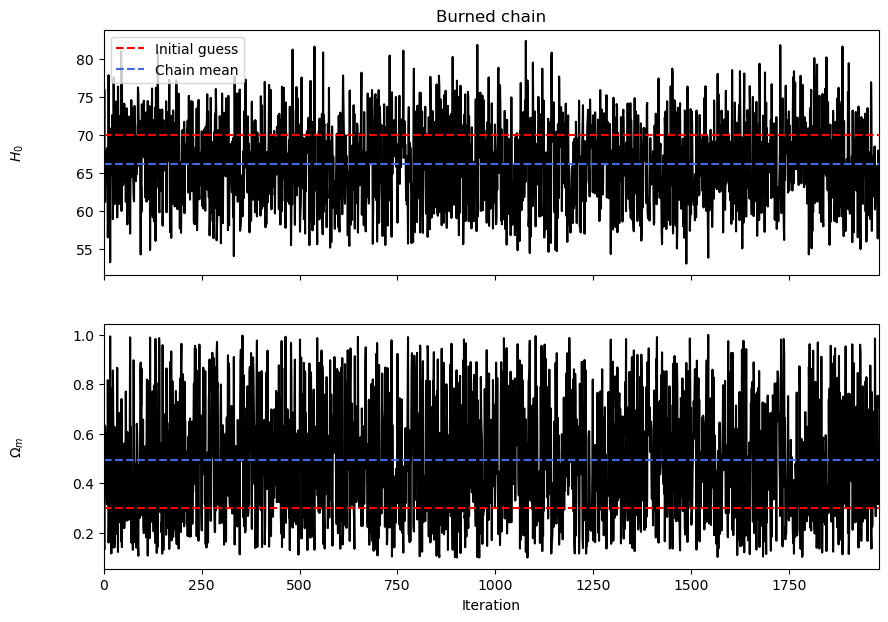

In [12]:
fig1, axes1 = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    axes1[i].plot(burned_trace[:,i], color = 'black')
    axes1[i].axhline(theta_guess[i], color = 'red', ls = '--', label = 'Initial guess')
    axes1[i].axhline(np.mean(burned_trace[:, i]), color = 'royalblue', ls = '--', label='Chain mean')
    axes1[i].set_xlim(0, len(burned_trace))
    axes1[i].set_ylabel(labels[i])
    axes1[i].yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel('Iteration')
axes1[0].legend()
axes1[0].set_title('Burned chain')
plt.show()

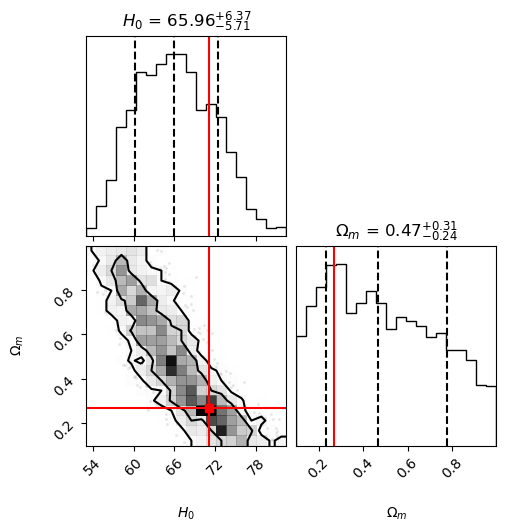

In [13]:
fig = corner.corner(burned_trace, labels=labels, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], truths=[71, 0.27], truth_color='red');

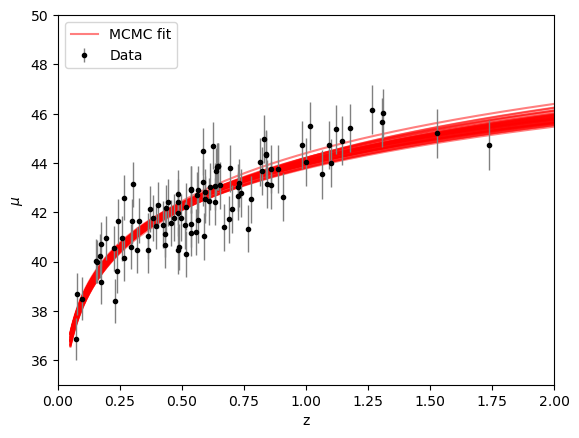

In [14]:
theta_mcmc = burned_trace[::50,:]
for i in range(len(theta_mcmc[:, 0])):
    if i==0:
        plt.plot(z_grid, model(z_grid, theta_mcmc[i, :]), color = 'red', alpha=0.5, label = 'MCMC fit')
    else:
        plt.plot(z_grid, model(z_grid, theta_mcmc[i, :]), color = 'red', alpha=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

#### Nested sampling

In [15]:
def LogLikelihood_nested(theta, z, mu):
    H, omega = theta
    if omega < 0:
        return -np.inf
    else:
        mu_fit = model(z, theta)
        return np.sum(scipy.stats.norm(loc=mu_fit, scale=dmu).logpdf(mu)) 

def Prior_nested(u):
    param = np.copy(u)
    param[0] = scipy.stats.uniform.ppf(u[0], loc = H_min, scale = H_max-H_min)
    param[1] = scipy.stats.uniform.ppf(u[1], loc = omega_min, scale = omega_max-omega_min)
    return param

In [16]:
ndim = 2
nested = dynesty.NestedSampler(LogLikelihood_nested, Prior_nested, ndim, logl_args=[z_sample, mu_sample], nlive = 10000)
nested.run_nested()
sresults = nested.results

8613it [00:39, 219.19it/s, +10000 | bound: 0 | nc: 1 | ncall: 33514 | eff(%): 79.157 | loglstar:   -inf < -132.813 <    inf | logz: -134.975 +/-    nan | dlogz:  0.000 > 10.009]


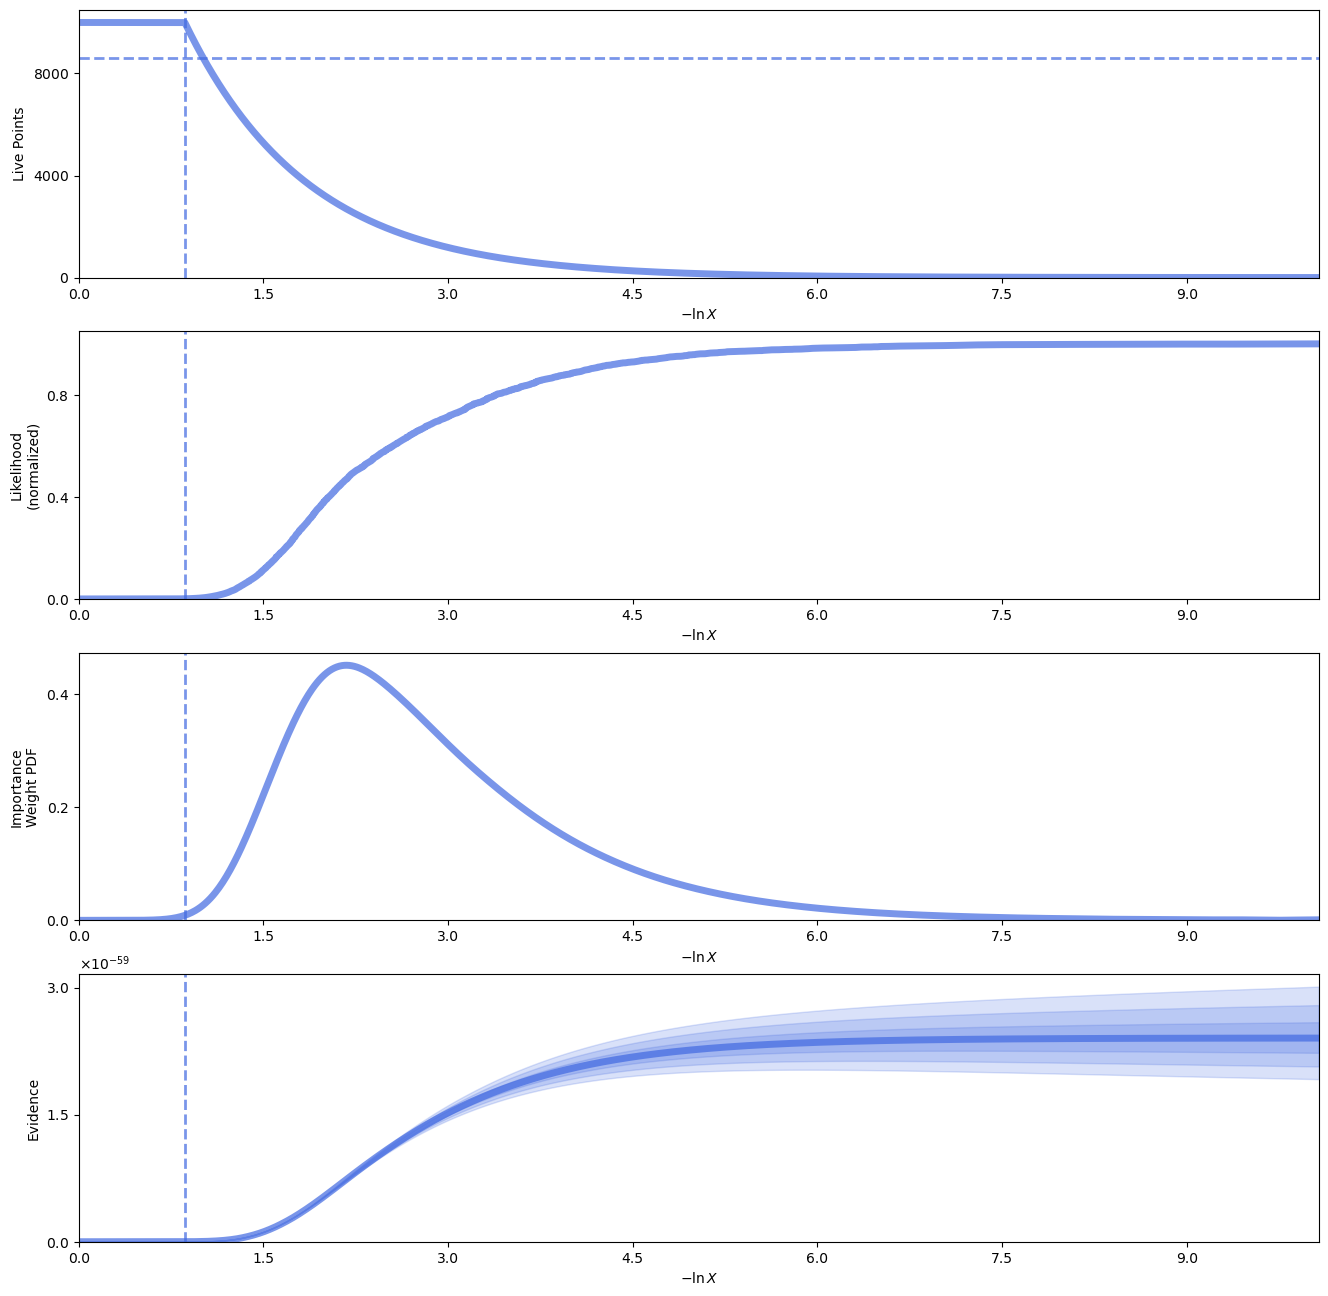

In [17]:
rfig, raxes = dyplot.runplot(sresults, color = 'royalblue')

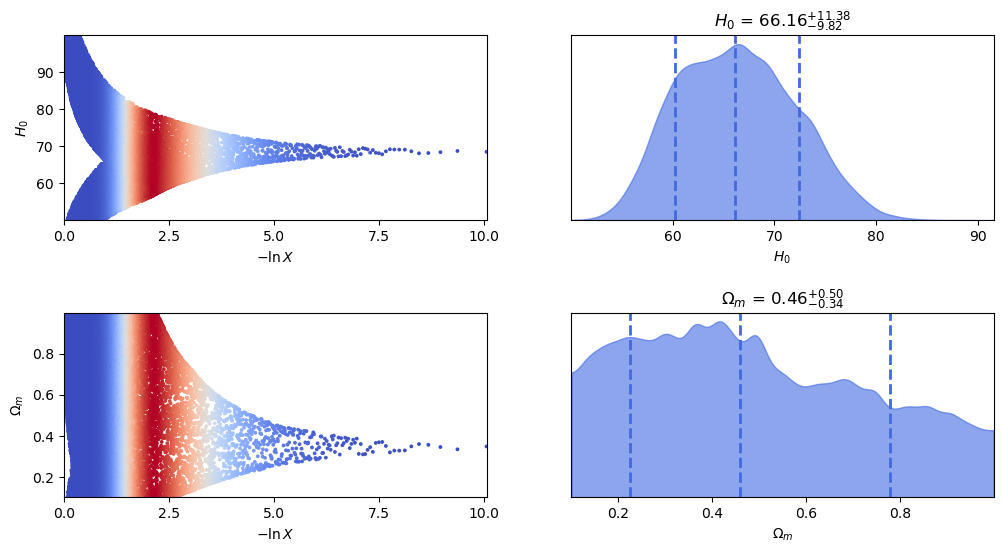

In [18]:
tfig, taxes = dyplot.traceplot(sresults, labels = labels, post_color='royalblue', trace_cmap='coolwarm', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

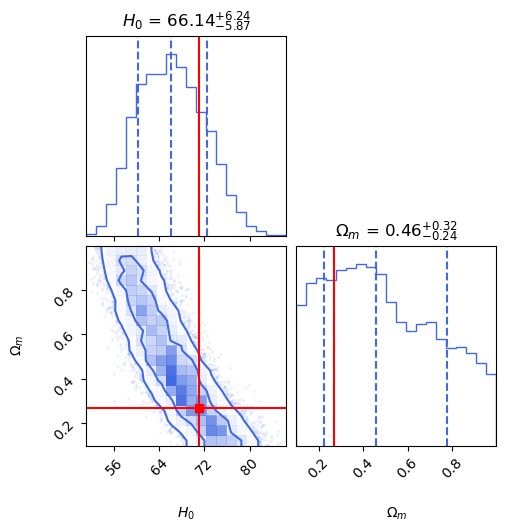

In [19]:
samples_nested = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])
samples_nested_equal = dyfunc.resample_equal(samples_nested, weights)
corner.corner(samples_nested_equal, labels=labels, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], color = 'royalblue', truths=[71, 0.27], truth_color='red');

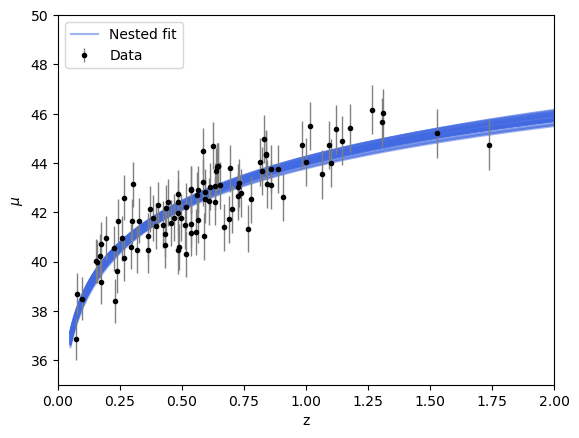

In [20]:
theta_nested = samples_nested_equal[::500, :]
for i in range(len(theta_nested[:, 0])):
    if i==0:
        plt.plot(z_grid, model(z_grid, theta_nested[i, :]), color = 'royalblue', alpha=0.5, label = 'Nested fit')
    else:
        plt.plot(z_grid, model(z_grid, theta_nested[i, :]), color = 'royalblue', alpha=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Parametric fit with $\Omega_m$ = 1

In [21]:
def model_nodark(z, theta):
    H = float(theta)
    cosmological = LambdaCDM(H0 = H, Om0 = 1, Ode0= 0)
    return cosmological.distmod(z).value

In [22]:
def LogLikelihood_nested_nodark(theta, z, mu):
    mu_fit = model_nodark(z, theta)
    return np.sum(scipy.stats.norm(loc=mu_fit, scale=dmu).logpdf(mu)) 

def Prior_nested_nodark(u):
    param = np.copy(u)
    param[0] = scipy.stats.uniform.ppf(u[0], loc = H_min, scale = H_max-H_min)
    return param

In [23]:
nested_nodark = dynesty.NestedSampler(LogLikelihood_nested_nodark, Prior_nested_nodark, 1, logl_args=[z_sample, mu_sample], nlive = 10000)
nested_nodark.run_nested()
sresults_nodark = nested_nodark.results

C:\Users\restu\AppData\Local\Temp\ipykernel_4340\206441890.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H = float(theta)
10290it [00:43, 235.50it/s, +10000 | bound: 0 | nc: 1 | ncall: 38016 | eff(%): 72.423 | loglstar:   -inf < -133.530 <    inf | logz: -135.585 +/-    nan | dlogz:  0.000 > 10.009]


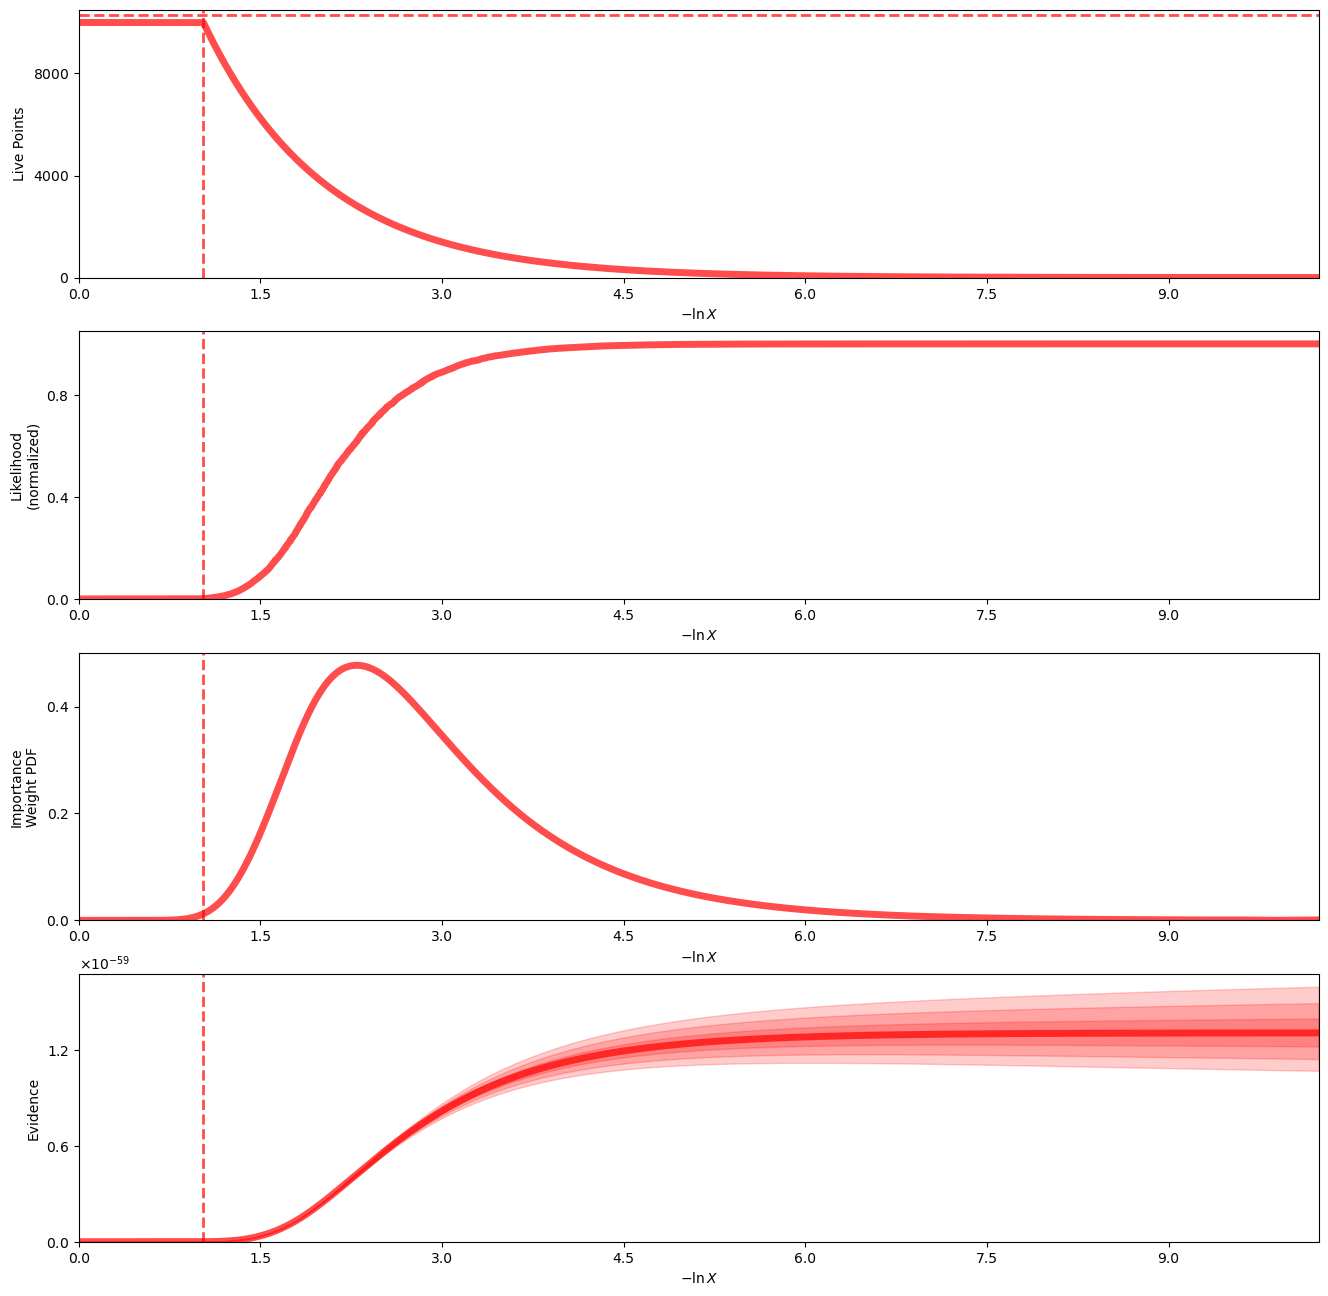

In [24]:
rfig_nodark, raxes_nodark = dyplot.runplot(sresults_nodark, color = 'red')

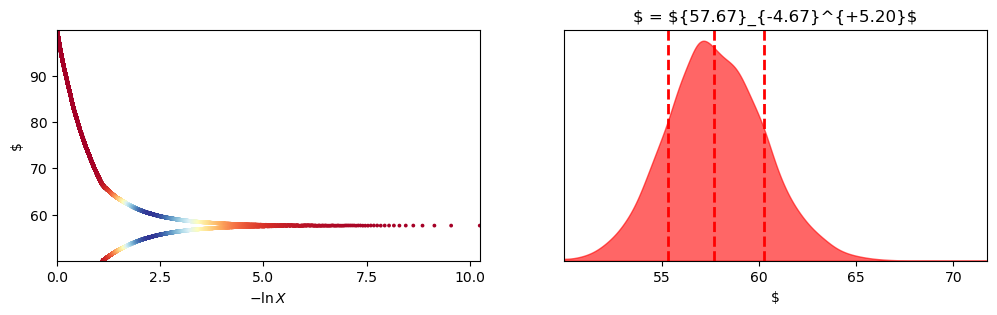

In [25]:
tfig_nodark, taxes_nodark = dyplot.traceplot(sresults_nodark, labels = labels[0], post_color='red', trace_cmap='RdYlBu', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

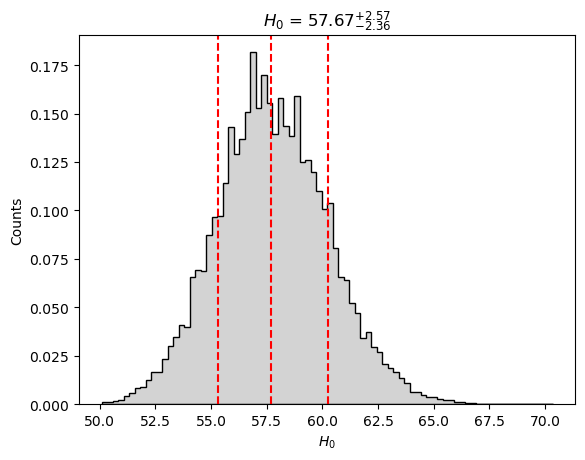

In [27]:
samples_nodark = sresults_nodark.samples  # samples
weights_nodark = np.exp(sresults_nodark.logwt - sresults_nodark.logz[-1])
samples_nodark_equal = dyfunc.resample_equal(samples_nodark, weights_nodark)

median = np.median(samples_nodark_equal)
perc = np.percentile(samples_nodark_equal, [16, 50, 84])
q = np.diff(perc)

fancyhist(samples_nodark_equal, bins="freedman", density=True, ec='black', fc='lightgrey', histtype='stepfilled')
plt.title(r'%s = $%0.2f^{+%0.2f}_{-%0.2f}$' %(labels[0], median, q[1], q[0]))
plt.axvline(perc[0], color = 'red', ls = '--')
plt.axvline(perc[1], color = 'red', ls = '--')
plt.axvline(perc[2], color = 'red', ls = '--')
plt.xlabel(labels[0])
plt.ylabel('Counts')
plt.show()

In [28]:
print('Dark energy model:')
sresults.summary()
print('\nNo dark energy model:')
sresults_nodark.summary()

Dark energy model:
Summary
nlive: 10000
niter: 8613
ncall: 23514
eff(%): 79.157
logz: -134.975 +/-  0.075

No dark energy model:
Summary
nlive: 10000
niter: 10290
ncall: 28016
eff(%): 72.423
logz: -135.585 +/-  0.067


In [29]:
print('The logarithmic Bayes factor is: ', np.log(np.exp(sresults.logz[-1])/np.exp(sresults_nodark.logz[-1])))

The logarithmic Bayes factor is:  0.6098752821822586


## Savage-Dickey density ratio

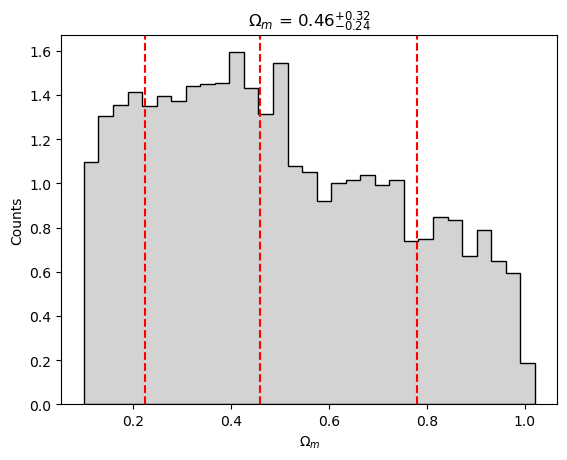

In [30]:
median_om = np.median(samples_nested_equal[:,1])
perc_om = np.percentile(samples_nested_equal[:,1], [16, 50, 84])
q_om = np.diff(perc_om)

fancyhist(samples_nested_equal[:,1], bins="freedman", density=True, ec='black', fc='lightgrey', histtype='stepfilled')
plt.title(r'%s = $%0.2f^{+%0.2f}_{-%0.2f}$' %(labels[1], median_om, q_om[1], q_om[0]))
plt.axvline(perc_om[0], color = 'red', ls = '--')
plt.axvline(perc_om[1], color = 'red', ls = '--')
plt.axvline(perc_om[2], color = 'red', ls = '--')
plt.xlabel(labels[1])
plt.ylabel('Counts')
plt.show()

In [31]:
bwrange = np.linspace(0.01, 0.2, 25)
k = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= k, verbose = 2)
grid.fit(samples_nested_equal[:,1][:, np.newaxis])
best_bw = grid.best_params_['bandwidth']
print(best_bw)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................bandwidth=0.01; total time=   2.1s
[CV] END .....................................bandwidth=0.01; total time=   2.0s
[CV] END .....................................bandwidth=0.01; total time=   2.1s
[CV] END .....................................bandwidth=0.01; total time=   2.1s
[CV] END .....................................bandwidth=0.01; total time=   2.0s
[CV] END .....................bandwidth=0.017916666666666668; total time=   2.1s
[CV] END .....................bandwidth=0.017916666666666668; total time=   2.1s
[CV] END .....................bandwidth=0.017916666666666668; total time=   2.0s
[CV] END .....................bandwidth=0.017916666666666668; total time=   2.0s
[CV] END .....................bandwidth=0.017916666666666668; total time=   2.1s
[CV] END .....................bandwidth=0.025833333333333333; total time=   2.2s
[CV] END .....................bandwidth=0.02583

In [32]:
o_grid = np.linspace(0.1, 1, 10000) 
kde_skl = KernelDensity(bandwidth = best_bw, kernel = 'gaussian')
kde_skl.fit(samples_nested_equal[:,1][:, np.newaxis])
log_pdf = kde_skl.score_samples(o_grid[:, np.newaxis])
pdf = np.exp(log_pdf)

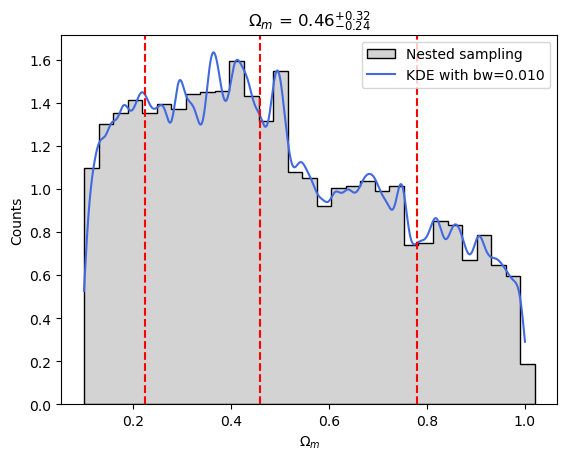

In [34]:
fancyhist(samples_nested_equal[:,1], bins="freedman", density=True, ec='black', fc='lightgrey', histtype='stepfilled', label='Nested sampling')
plt.title(r'%s = $%0.2f^{+%0.2f}_{-%0.2f}$' %(labels[1], median_om, q_om[1], q_om[0]))
plt.plot(o_grid, pdf, color = 'royalblue', label = 'KDE with bw=%0.3f' %best_bw)
plt.axvline(perc_om[0], color = 'red', ls = '--')
plt.axvline(perc_om[1], color = 'red', ls = '--')
plt.axvline(perc_om[2], color = 'red', ls = '--')
plt.xlabel(labels[1])
plt.ylabel('Counts')
plt.legend()
plt.show()

In [35]:
SDR = np.log((1/(omega_max-omega_min))/pdf[o_grid==1])
print('The logarithmic Savage-Dickey ratio is', SDR[0])

The logarithmic Savage-Dickey ratio is 1.3418125356339714


This means that, according to the Jeffrey scale, there is a weak evidence that the narrow model is preffered to the broader model

## Cloning data

#### GPR

In [36]:
bwrange_z = np.linspace(0.01, 1, 1000)
k = 5
grid_z = GridSearchCV(KernelDensity(), {'bandwidth': bwrange_z}, cv= k)
grid_z.fit(z_sample[:, np.newaxis])
best_bw_z = grid_z.best_params_['bandwidth']
print(best_bw_z)

0.13585585585585588


In [37]:
kde_z = KernelDensity(bandwidth = best_bw_z, kernel = 'gaussian')
kde_z.fit(z_sample[:, np.newaxis])
log_pdf_z = kde_z.score_samples(z_grid[:, np.newaxis])
pdf_z = np.exp(log_pdf_z)

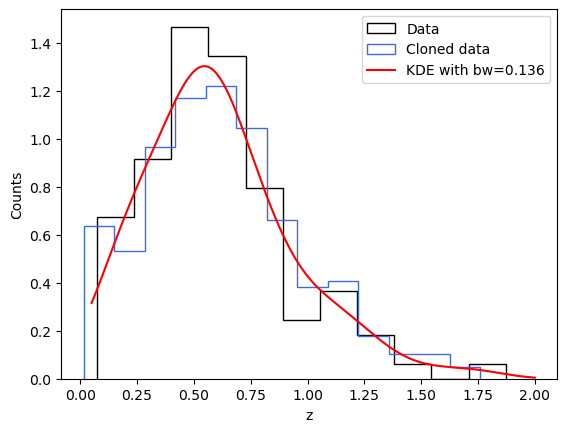

In [42]:
z_clone = kde_z.sample(300).ravel()
z_clone = z_clone[z_clone>0]

fancyhist(z_sample, bins="freedman", density=True, ec='black', histtype='step', label='Data')
fancyhist(z_clone, bins="freedman", density=True, ec='royalblue', histtype='step', label='Cloned data')
plt.plot(z_grid, pdf_z, color = 'red', label = 'KDE with bw=%0.3f' %best_bw_z)
plt.xlabel('z')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [85]:
mus = gp.sample_y(z_clone[:, np.newaxis], 10000)
mu_clone = np.zeros(len(z_clone))
mu_std = np.zeros(len(z_clone))
for i in range(len(z_clone)):
    mu_clone[i] = mus[i, np.random.randint(0, 100)]
    #mu_std[i] = np.std(mus[i, :])

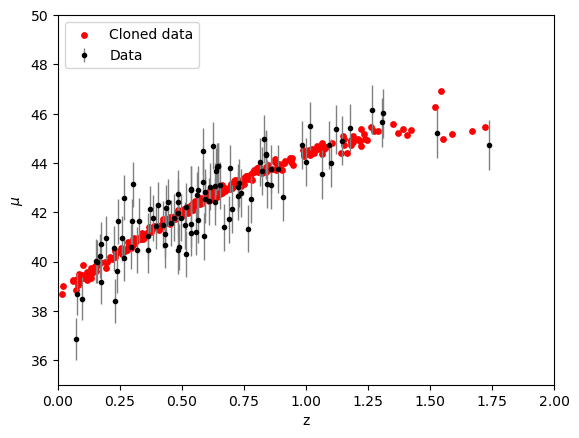

In [86]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
#plt.errorbar(z_clone, mu_clone, mu_std, fmt='.r', ecolor='orange', lw=1,label='Cloned data')
plt.scatter(z_clone, mu_clone, color = 'red', label='Cloned data', s=15)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

#### MCMC (NON RIESCO A RIPRODURRE LO SPREAD)

In [96]:
for i in range(len(z_clone)):
    par = burned_trace[np.random.randint(0, len(burned_trace[:,0]))]
    mu_cloned_mcmc = model(z_clone, par)

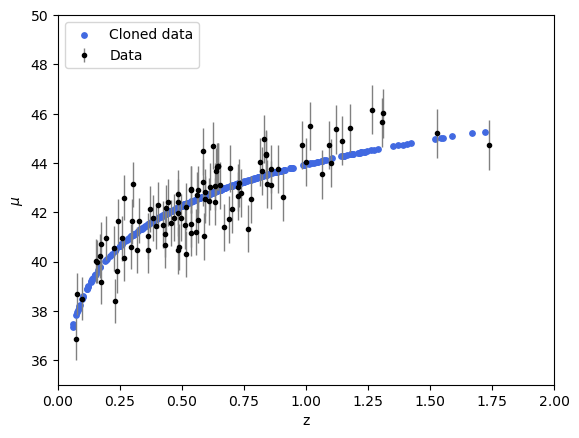

In [97]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
#plt.errorbar(z_clone, mu_clone, mu_std, fmt='.r', ecolor='orange', lw=1,label='Cloned data')
plt.scatter(z_clone, mu_clone_mcmc, color = 'royalblue', label='Cloned data', s=15)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()